# Model Comparison — Combined UCI Heart Dataset
This notebook aggregates and compares performance across all models trained on the **combined_uci_heart** dataset, including:
- Logistic Regression  
- XGBoost  
- Support Vector Machine (SVM)  
- Neural Network  
- Transformer  

It also performs 10-fold cross-validation for classical models and summarizes results with mean ± std accuracy/AUC.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

dataset_name="combined_uci_heart"
BASE_DIR=os.path.abspath(os.path.join(os.getcwd(),".."))
PROCESSED_DIR=os.path.join(BASE_DIR,"data","processed")
RESULTS_DIR=os.path.join(BASE_DIR,"experiments","results")
print("Using dataset:",dataset_name)


Using dataset: combined_uci_heart


## Load Saved Metrics and Compare All Models

In [3]:
metrics_files=[f for f in os.listdir(RESULTS_DIR) if f.endswith(f"{dataset_name}_metrics.csv")]
records=[]
for file in metrics_files:
    df=pd.read_csv(os.path.join(RESULTS_DIR,file),index_col=0)
    name=file.replace(f"_{dataset_name}_metrics.csv","")
    acc=df.loc["accuracy","f1-score"] if "accuracy" in df.index else np.nan
    macro_f1=df.loc["macro avg","f1-score"] if "macro avg" in df.index else np.nan
    records.append({"Model":name,"Accuracy":acc,"Macro F1":macro_f1})
metrics_df=pd.DataFrame(records).sort_values("Accuracy",ascending=False)
display(metrics_df)


,Model,Accuracy,Macro F1
4,xgboost,0.833333,0.830317
0,logistic_regression,0.816667,0.814137
2,svm,0.816667,0.814137
1,neural_network,0.800000,0.797980
3,transformer,0.750000,0.737686


### Visualize saved model metrics

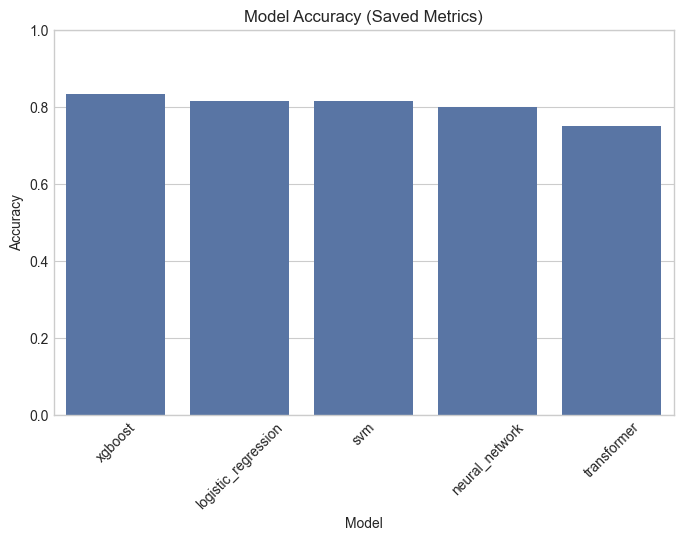

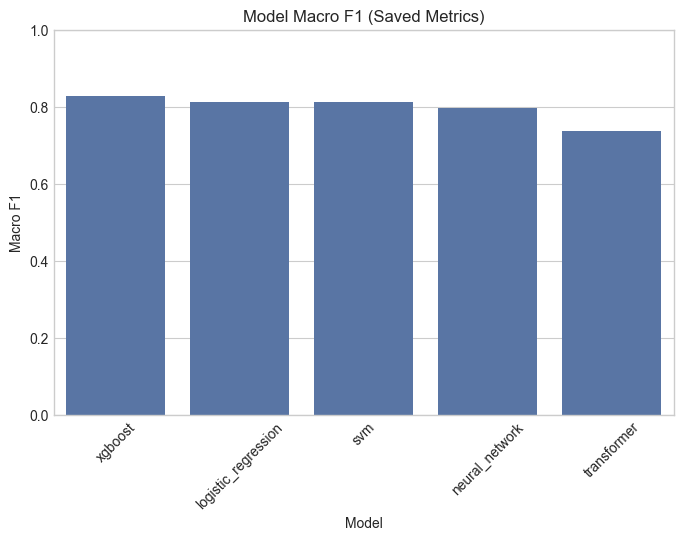

In [4]:
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df,x="Model",y="Accuracy")
plt.title("Model Accuracy (Saved Metrics)")
plt.ylim(0,1);plt.xticks(rotation=45);plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df,x="Model",y="Macro F1")
plt.title("Model Macro F1 (Saved Metrics)")
plt.ylim(0,1);plt.xticks(rotation=45);plt.show()


## 10-Fold Cross-Validation for Classical Models

In [5]:
X=joblib.load(os.path.join(PROCESSED_DIR,f"{dataset_name}_X.joblib"))
y=joblib.load(os.path.join(PROCESSED_DIR,f"{dataset_name}_y.joblib"))
if hasattr(X,"toarray"): X=X.toarray()

models={
    "LogisticRegression":LogisticRegression(max_iter=1000,solver="lbfgs"),
    "SVM":SVC(kernel="rbf",probability=True,C=1.0,gamma="scale"),
    "XGBoost":XGBClassifier(
        n_estimators=300,max_depth=4,learning_rate=0.05,
        subsample=0.8,colsample_bytree=0.8,eval_metric="logloss",random_state=42
    )
}
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
cv=[]
for name,model in models.items():
    accs,aucs=[],[]
    print(f"\n🔁 10-fold CV for {name}")
    for fold,(train_idx,test_idx) in enumerate(skf.split(X,y),1):
        Xtr,Xte=X[train_idx],X[test_idx]; ytr, yte=y[train_idx],y[test_idx]
        model.fit(Xtr,ytr)
        ypred=model.predict(Xte)
        yproba=model.predict_proba(Xte)[:,1]
        accs.append(accuracy_score(yte,ypred))
        aucs.append(roc_auc_score(yte,yproba))
        print(f"  Fold {fold}: acc={accs[-1]:.3f}, auc={aucs[-1]:.3f}")
    cv.append({
        "Model":name,
        "CV_Accuracy_mean":np.mean(accs),"CV_Accuracy_std":np.std(accs),
        "CV_AUC_mean":np.mean(aucs),"CV_AUC_std":np.std(aucs)
    })
cv_df=pd.DataFrame(cv)
cv_df



🔁 10-fold CV for LogisticRegression
  Fold 1: acc=0.767, auc=0.799
  Fold 2: acc=0.933, auc=0.996
  Fold 3: acc=0.933, auc=0.964
  Fold 4: acc=0.733, auc=0.875
  Fold 5: acc=0.867, auc=0.969
  Fold 6: acc=0.733, auc=0.795
  Fold 7: acc=0.867, auc=0.946
  Fold 8: acc=0.800, auc=0.902
  Fold 9: acc=0.967, auc=0.987
  Fold 10: acc=0.724, auc=0.774

🔁 10-fold CV for SVM
  Fold 1: acc=0.767, auc=0.786
  Fold 2: acc=0.933, auc=0.987
  Fold 3: acc=0.900, auc=0.951
  Fold 4: acc=0.700, auc=0.875
  Fold 5: acc=0.800, auc=0.915
  Fold 6: acc=0.667, auc=0.812
  Fold 7: acc=0.900, auc=0.951
  Fold 8: acc=0.800, auc=0.888
  Fold 9: acc=0.933, auc=0.955
  Fold 10: acc=0.793, auc=0.851

🔁 10-fold CV for XGBoost
  Fold 1: acc=0.733, auc=0.795
  Fold 2: acc=0.833, auc=0.982
  Fold 3: acc=0.867, auc=0.946
  Fold 4: acc=0.700, auc=0.879
  Fold 5: acc=0.800, auc=0.920
  Fold 6: acc=0.700, auc=0.723
  Fold 7: acc=0.900, auc=0.951
  Fold 8: acc=0.800, auc=0.906
  Fold 9: acc=0.933, auc=0.933
  Fold 10: acc

,Model,CV_Accuracy_mean,CV_Accuracy_std,CV_AUC_mean,CV_AUC_std
0,LogisticRegression,0.832414,0.088017,0.900618,0.080878
1,SVM,0.819310,0.089868,0.897150,0.063069
2,XGBoost,0.795632,0.083524,0.883860,0.079127


### Cross-validation results plots

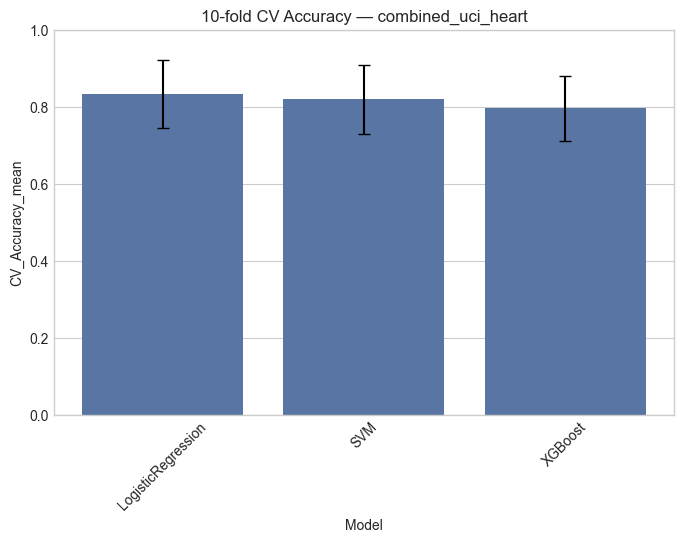

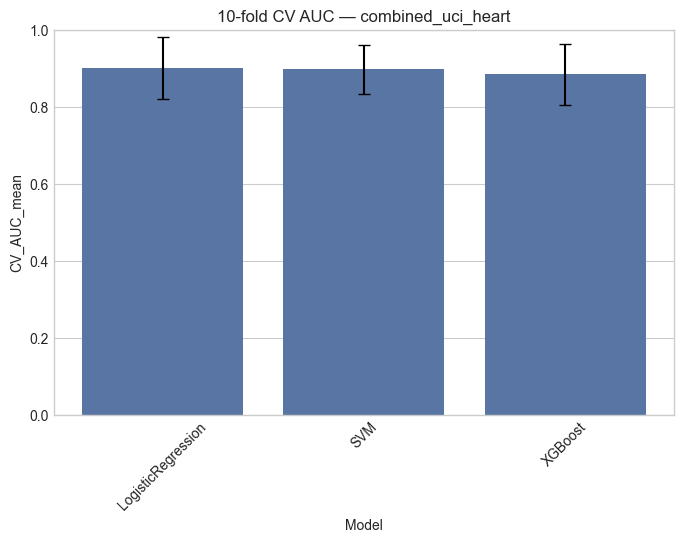

In [6]:
# accuracy plot
plt.figure(figsize=(8,5))
sns.barplot(data=cv_df,x="Model",y="CV_Accuracy_mean",errorbar=None)
plt.errorbar(np.arange(len(cv_df)),cv_df["CV_Accuracy_mean"],yerr=cv_df["CV_Accuracy_std"],fmt="none",ecolor="black",capsize=4)
plt.title(f"10-fold CV Accuracy — {dataset_name}")
plt.ylim(0,1);plt.xticks(rotation=45);plt.show()

# auc plot
plt.figure(figsize=(8,5))
sns.barplot(data=cv_df,x="Model",y="CV_AUC_mean",errorbar=None)
plt.errorbar(np.arange(len(cv_df)),cv_df["CV_AUC_mean"],yerr=cv_df["CV_AUC_std"],fmt="none",ecolor="black",capsize=4)
plt.title(f"10-fold CV AUC — {dataset_name}")
plt.ylim(0,1);plt.xticks(rotation=45);plt.show()


## Combine Saved Metrics and CV Results

In [7]:
# merge approximate metrics with CV means
merged=pd.merge(metrics_df,cv_df,left_on="Model",right_on="Model",how="outer")
merged=merged.sort_values("CV_AUC_mean",ascending=False)
display(merged)

out_path=os.path.join(RESULTS_DIR,"crossval_summary_combined_uci_heart.csv")
merged.to_csv(out_path,index=False)
print("✅ Summary exported to:",out_path)


,Model,Accuracy,Macro F1,CV_Accuracy_mean,CV_Accuracy_std,CV_AUC_mean,CV_AUC_std
0,LogisticRegression,NaN,NaN,0.832414,0.088017,0.900618,0.080878
1,SVM,NaN,NaN,0.819310,0.089868,0.897150,0.063069
2,XGBoost,NaN,NaN,0.795632,0.083524,0.883860,0.079127
3,logistic_regression,0.816667,0.814137,NaN,NaN,NaN,NaN
4,neural_network,0.800000,0.797980,NaN,NaN,NaN,NaN
5,svm,0.816667,0.814137,NaN,NaN,NaN,NaN
6,transformer,0.750000,0.737686,NaN,NaN,NaN,NaN
7,xgboost,0.833333,0.830317,NaN,NaN,NaN,NaN


✅ Summary exported to: c:\Users\user\CardioVescular_Disease_prediction\experiments\results\crossval_summary_combined_uci_heart.csv


## Final Comparison Plot (All Models)

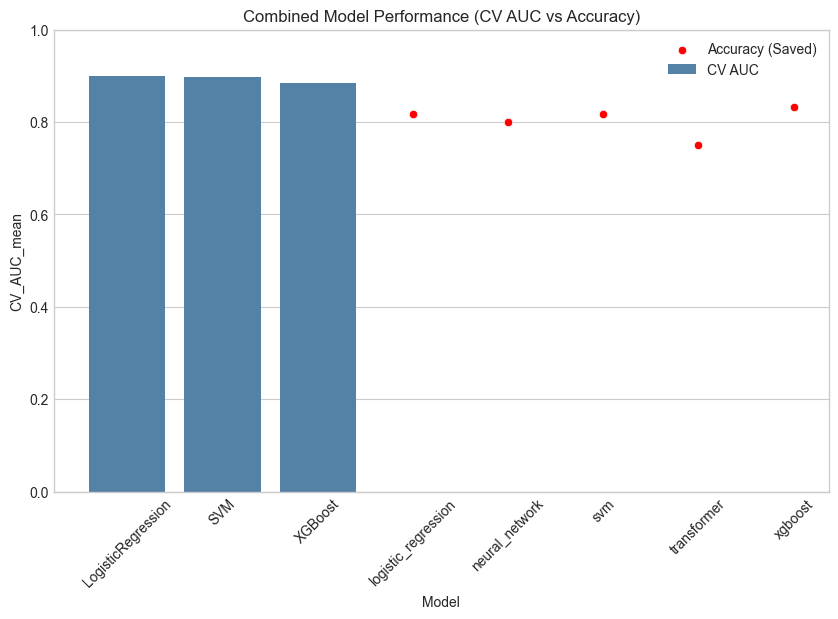

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(data=merged,x="Model",y="CV_AUC_mean",color="steelblue",label="CV AUC")
sns.scatterplot(data=merged,x="Model",y="Accuracy",color="red",label="Accuracy (Saved)")
plt.title("Combined Model Performance (CV AUC vs Accuracy)")
plt.xticks(rotation=45);plt.ylim(0,1);plt.legend();plt.show()


## Feature Importance — XGBoost

<Figure size 800x600 with 0 Axes>

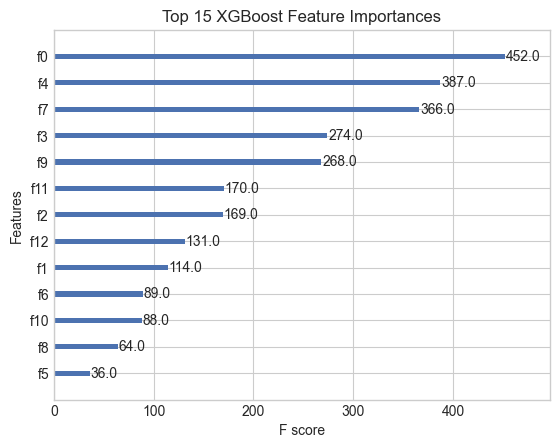

In [9]:
xgb_full=XGBClassifier(
    n_estimators=300,max_depth=4,learning_rate=0.05,
    subsample=0.8,colsample_bytree=0.8,eval_metric="logloss",random_state=42
)
xgb_full.fit(X,y)
plt.figure(figsize=(8,6))
plot_importance(xgb_full,max_num_features=15)
plt.title("Top 15 XGBoost Feature Importances")
plt.show()
